<a name="init"></a>
<h1>Brain Tumor Classifier</h1>

#### Autor: [Juan Manuel Cornejo](https://www.linkedin.com/in/juanmanuelcornejociruelo/)

En este notebook encontrarás los modelos de CNN entrenados para la clasificación de MRI con o sin tummor, usando ImageDataGenerator en el proceso.

<dl>
  <dt><a href="#Librerias">1. Importar librerías</a></dt>
      <dd>Librerías usadas</dd>
    
  <dt><a href="#Constantes">2. Constantes usadas</a></dt>
      <dd>Tamaño de imagen , paths, epochs</dd>
    
  <dt><a href="#Funciones_visualizacion">3. Funciones de visualización</a></dt>
      <dd>Funciones de visualización usadas en el notebook</dd>
      <dd>3.1 Visualización iamgen suelta</dd>
      <dd>3.2 Visualización historico entrenamiento</dd>
    
  <dt><a href="#Funcion_testeo">4. Función de test</a></dt>
      <dd>Función cpara verificar las predicciones</dd>
    
  <dt><a href="#Carga_verificacion">5. Carga y verificación dataframe</a></dt>
      <dd>Cargamos el dataframe creado en el notebook de normalización</dd>
      <dd>Tratamos sus datos apra trabajar con el a continuación y los verificamos</dd>
    
  <dt><a href="#ImageDataGenerator">6. Image Data Generator</a></dt>
      <dd>Script apra usar image data generator de Keras</dd>
 
  <dt><a href="#Funcion_callback">7. Función de Earlystop y guardo</a></dt>
      <dd>Función para parar entrenamiento y guardar el mejor modelo</dd>
   
  <dt><a href="#VGG16">8. Modelo VVG16</a></dt>
      <dd>Modelo VGG16, entrenamiento y verificación de resultados</dd>
    
  <dt><a href="#Inception_V3">9. Modelo Inception V3</a></dt>
      <dd>Modelo Inception_V3, entrenamiento y verificación de resultados</dd>
    
   <dt><a href="#VGG19">10. Modelo VVG19</a></dt>
      <dd>Modelo VGG19, entrenamiento y verificación de resultados</dd>
    
</dl>

<a name="Librerias"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
### Importamos librerías

In [38]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.io import imread
import cv2
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_inputVGG16
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_inputInceptionV3
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_inputVGG19

<a name="Constantes"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
### Preparación de constantes

In [2]:
PATH = "/Users/jcornejo/Desktop/Brain Tumor ML/data/Brain_tumor_dataset_normalizado/"
PATH_MODEL ="/Users/jcornejo/Desktop/Brain Tumor ML/model/"

IMG_SIZE = 255

EPOCHS = 50

<a name="Funciones_visualizacion"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
### Funciones de visualización

In [39]:
def display_random_image(y_test, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(y_test[index])
    plt.show()

In [40]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(25,8))

    # Plot accuracy5
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(history.epoch) + 1)


    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Set')
    plt.plot(epochs_range, val_acc, label='Val Set')
    plt.legend(loc="best")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Set')
    plt.plot(epochs_range, val_loss, label='Val Set')
    plt.legend(loc="best")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')

    plt.tight_layout()
    plt.show()

<a name="Funcion_testeo"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
### Función de testeo

In [41]:
def pred_input(modelo, nombre_pred,IMG_SIZE, test_df):
    random = np.random.randint(1,len(test_df))
    img = image.load_img(PATH + (test_df.loc[random,"Filename"]), target_size=(IMG_SIZE, IMG_SIZE))
    
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    
    img_preprocessed = nombre_pred(img_batch)
    
    prediction = modelo.predict(img_preprocessed)
    
    print('Predicción:',prediction)
    plt.imshow(cv2.imread(PATH + (test_df.loc[random,"Filename"])))
    plt.title(test_df.loc[random,"Target"])
    plt.show();
# pred_input(model, preprocess_inputVGG19,IMG_SIZE, test_df)

<a name="Carga_verificacion"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
# Cargamos el DF  que preparamos en el notebook de normalización
* Como recordatorio, en dicho notebook, buscamos el perímeto máximo de la imagen, quitando ruido, para así que todas las imagenens se centrasen en al resonancia y no otros datos como podía ser el numero de resonancia, hospital etc...
* Despúes de normalizar las imagenes según dicho patron, creamos un df , con el nombre de las imagenenes y su target ( Sin tumor = 0, Tumor = 1)
* Y verificamos que el Dataset está un poco desvalanceado.

In [6]:
df = pd.read_csv('../data/df_tumor.csv')
df.head()

,Filename,Target
0,yes.5_normalizada.jpg,1
1,no.51_normalizada.jpg,0
2,yes.53_normalizada.jpg,1
3,yes.136_normalizada.jpg,1
4,yes.14_normalizada.jpg,1


In [7]:
df['Target'] = df['Target'].astype(str)
df.dtypes

Filename    object
Target      object
dtype: object

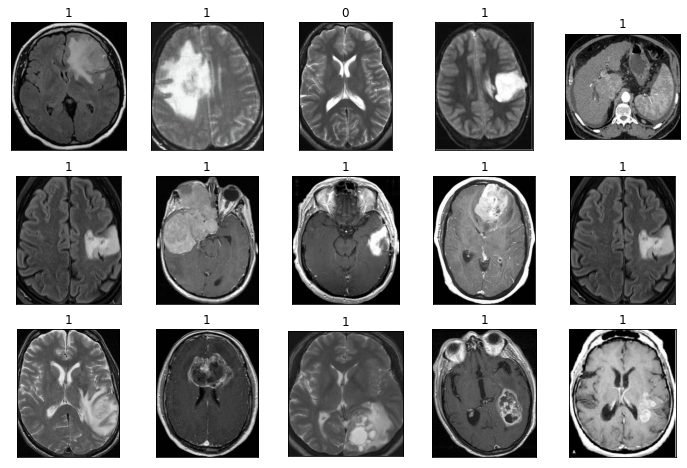

In [8]:
plt.figure(figsize=(12,8))

for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(PATH + (df.loc[random,"Filename"])))
    plt.xticks([])
    plt.yticks([])

    plt.title(df.loc[random,"Target"])

plt.show();

### Creamos el split para test , train y validation

In [42]:
#Separamos en train y test
train_aux_df, test_df = train_test_split(df,
                                    test_size=0.10,
                                    random_state=42)

train_aux_df = train_aux_df.reset_index(drop=True)

#Separamos en train y validate
train_df, validate_df = train_test_split(train_aux_df,
                                    test_size=0.20,
                                    random_state=42)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

### Verifico test

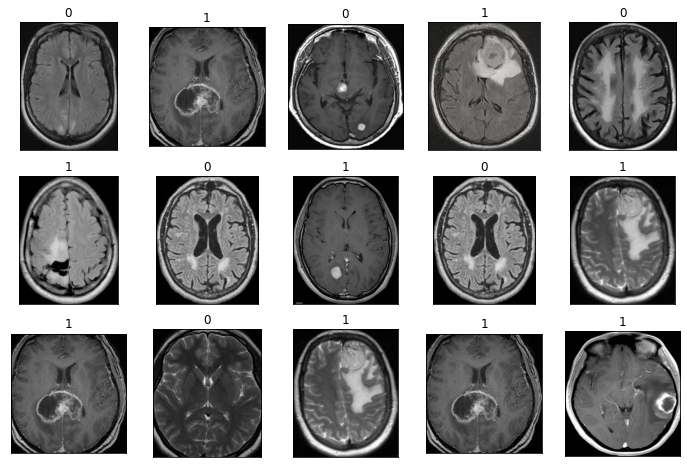

In [43]:
plt.figure(figsize=(12,8))

for i in range(15):
    random = np.random.randint(1,len(test_df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(PATH + (test_df.loc[random,"Filename"])))
    plt.xticks([])
    plt.yticks([])

    plt.title(test_df.loc[random,"Target"])

plt.show();

### Verifico train

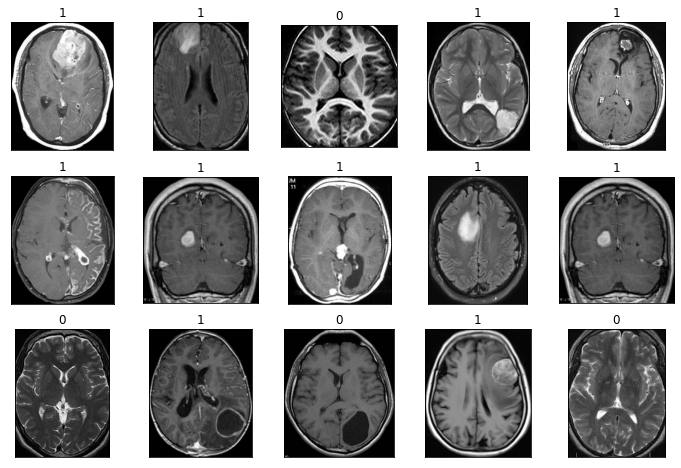

In [44]:
plt.figure(figsize=(12,8))

for i in range(15):
    random = np.random.randint(1,len(train_df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(PATH + (train_df.loc[random,"Filename"])))
    plt.xticks([])
    plt.yticks([])

    plt.title(train_df.loc[random,"Target"])

plt.show();

### Verifico validación

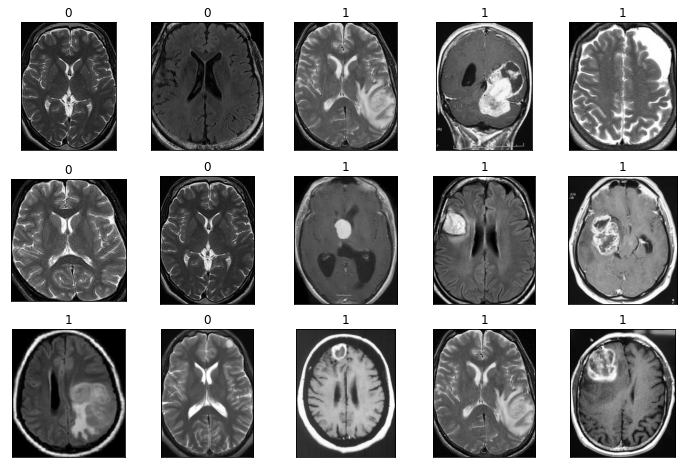

In [45]:
plt.figure(figsize=(12,8))

for i in range(15):
    random = np.random.randint(1,len(validate_df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(PATH + (validate_df.loc[random,"Filename"])))
    plt.xticks([])
    plt.yticks([])

    plt.title(validate_df.loc[random,"Target"])

plt.show();

<a name="ImageDataGenerator"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a>
### Como la cantidad de datos que tenemos es limitada, usaremos generador de imagenes

* keras.preprocessing.image import ImageDataGenerator

In [46]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data and test should not be augmented!
validation_datagen = ImageDataGenerator(rescale = 1.0/255.)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [47]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    PATH,
                                                    x_col='Filename',
                                                    y_col='Target',
                                                    batch_size = 10,
                                                    class_mode = 'binary',
                                                    target_size = (IMG_SIZE, IMG_SIZE) )

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_dataframe(validate_df,
                                                              PATH,
                                                              x_col='Filename',
                                                              y_col='Target',
                                                              batch_size = 10,
                                                              class_mode = 'binary',
                                                              target_size = (IMG_SIZE, IMG_SIZE))

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                  PATH,
                                                  x_col = 'Filename',
                                                  y_col ='Target',
                                                  class_mode = 'binary',
                                                  batch_size = 10,
                                                  target_size = (IMG_SIZE, IMG_SIZE),
                                                  shuffle = False)

Found 181 validated image filenames belonging to 2 classes.
Found 46 validated image filenames belonging to 2 classes.
Found 26 validated image filenames belonging to 2 classes.


<a name="Funcion_callback"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a>
### Declaro función para guardar mejor modelo y earlystoppling

In [48]:
def call_backs(nombre_modelo):
    callbacks = [
                ModelCheckpoint(nombre_modelo, save_best_only=True, verbose = 0),
                EarlyStopping(patience=3, monitor='val_loss', verbose=1),
    ]
    return callbacks

<a name="VGG16"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a>
## Modelo CNN VGG16

In [49]:
base_model = VGG16(input_shape = (IMG_SIZE,IMG_SIZE,3),
                  include_top = False,
                  weights = 'imagenet'  #None para entrenarla de cero sin quedarte la parte convolucionada preentrenada
                  ) 

for layer in base_model.layers:
    layer.trainable = False

##### FULLY CONNECTED LAYER #####
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(2048, activation='relu')(x)


# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

modelVGG16 = tf.keras.models.Model(base_model.input, x)

modelVGG16.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics = ['accuracy'])

In [51]:
vgghist16 = modelVGG16.fit(train_generator,
                    validation_data = validation_generator,
                    callbacks = [call_backs(PATH_MODEL + "Tumor_classifier_model_VGG16.h5")],
                    epochs = EPOCHS,
                    verbose = 1)

Epoch 1/50
19/19 [==============================] - 39s 2s/step - loss: 4.2891 - accuracy: 0.5193 - val_loss: 2.2453 - val_accuracy: 0.7174
Epoch 2/50
19/19 [==============================] - 38s 2s/step - loss: 2.8628 - accuracy: 0.6298 - val_loss: 3.3174 - val_accuracy: 0.5435
Epoch 3/50
19/19 [==============================] - 39s 2s/step - loss: 2.5817 - accuracy: 0.6298 - val_loss: 1.6634 - val_accuracy: 0.7391
Epoch 4/50
19/19 [==============================] - 37s 2s/step - loss: 1.5328 - accuracy: 0.7182 - val_loss: 1.4203 - val_accuracy: 0.7609
Epoch 5/50
19/19 [==============================] - 37s 2s/step - loss: 1.7787 - accuracy: 0.6685 - val_loss: 1.0673 - val_accuracy: 0.8261
Epoch 6/50
19/19 [==============================] - 38s 2s/step - loss: 0.8160 - accuracy: 0.7680 - val_loss: 1.0223 - val_accuracy: 0.7609
Epoch 7/50
19/19 [==============================] - 37s 2s/step - loss: 0.7783 - accuracy: 0.7624 - val_loss: 0.6037 - val_accuracy: 0.7826
Epoch 8/50
19/19 [==

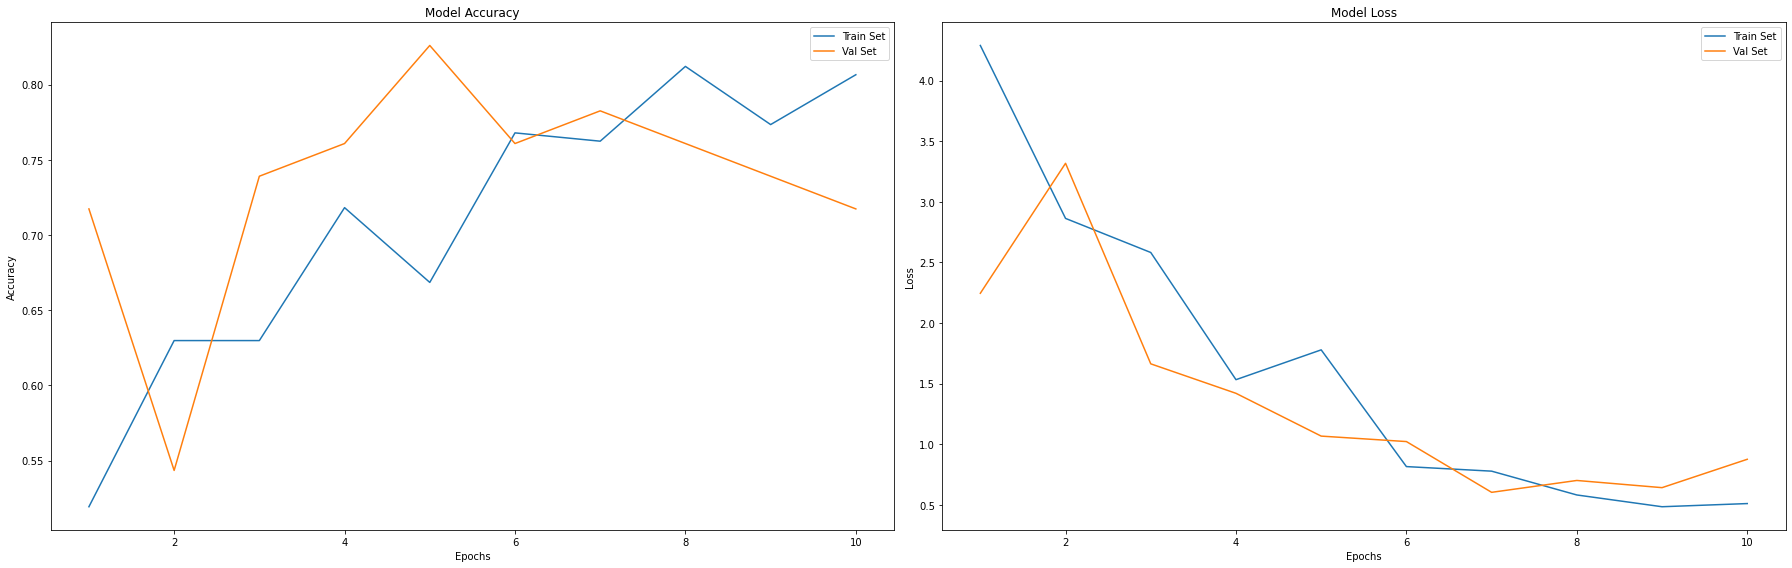

In [52]:
plot_accuracy_loss(vgghist16)

In [53]:
modelVGG16.load_weights(PATH_MODEL + "Tumor_classifier_model_VGG16.h5")
modelVGG16.evaluate(test_generator)

3/3 [==============================] - 3s 1s/step - loss: 0.6715 - accuracy: 0.8077


[0.6714684367179871, 0.807692289352417]

### Predicciones VGG16

Predicción: [[1.]]


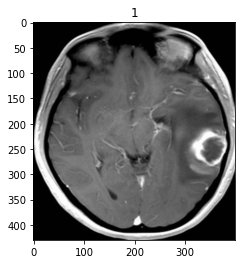

In [54]:
pred_input(modelVGG16, preprocess_inputVGG16,IMG_SIZE, test_df)

<a name="Inception_V3"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a>
## Modelo CNN InceptionV3

In [59]:
base_model = InceptionV3(input_shape = (IMG_SIZE,IMG_SIZE,3),
                  include_top = False,
                  weights = 'imagenet'  #None para entrenarla de cero sin quedarte la parte convolucionada preentrenada
                  )

for layer in base_model.layers:
    layer.trainable = False
    
x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation = 'relu')(x)

x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation = 'sigmoid')(x)

modelV3 = tf.keras.models.Model(base_model.input, x)

modelV3.compile(optimizer = 'rmsprop',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [60]:
histincV3 =modelV3.fit(train_generator,
                 validation_data = validation_generator,
                 callbacks = [call_backs(PATH_MODEL + "Tumor_classifier_model_InceptionV3.h5")],
                 epochs = EPOCHS,
                 verbose = 1)

Epoch 1/50
19/19 [==============================] - 26s 1s/step - loss: 62.4674 - accuracy: 0.5856 - val_loss: 14.1562 - val_accuracy: 0.5217
Epoch 2/50
19/19 [==============================] - 18s 954ms/step - loss: 15.8509 - accuracy: 0.6630 - val_loss: 24.0233 - val_accuracy: 0.7174
Epoch 3/50
19/19 [==============================] - 19s 979ms/step - loss: 17.7827 - accuracy: 0.6575 - val_loss: 6.9398 - val_accuracy: 0.6522
Epoch 4/50
19/19 [==============================] - 19s 970ms/step - loss: 7.7240 - accuracy: 0.7459 - val_loss: 12.4288 - val_accuracy: 0.7174
Epoch 5/50
19/19 [==============================] - 20s 1s/step - loss: 12.2123 - accuracy: 0.7348 - val_loss: 29.1789 - val_accuracy: 0.3696
Epoch 6/50
19/19 [==============================] - 19s 965ms/step - loss: 10.5244 - accuracy: 0.6796 - val_loss: 4.9806 - val_accuracy: 0.7609
Epoch 7/50
19/19 [==============================] - 19s 997ms/step - loss: 5.6692 - accuracy: 0.7403 - val_loss: 3.6164 - val_accuracy: 0.6

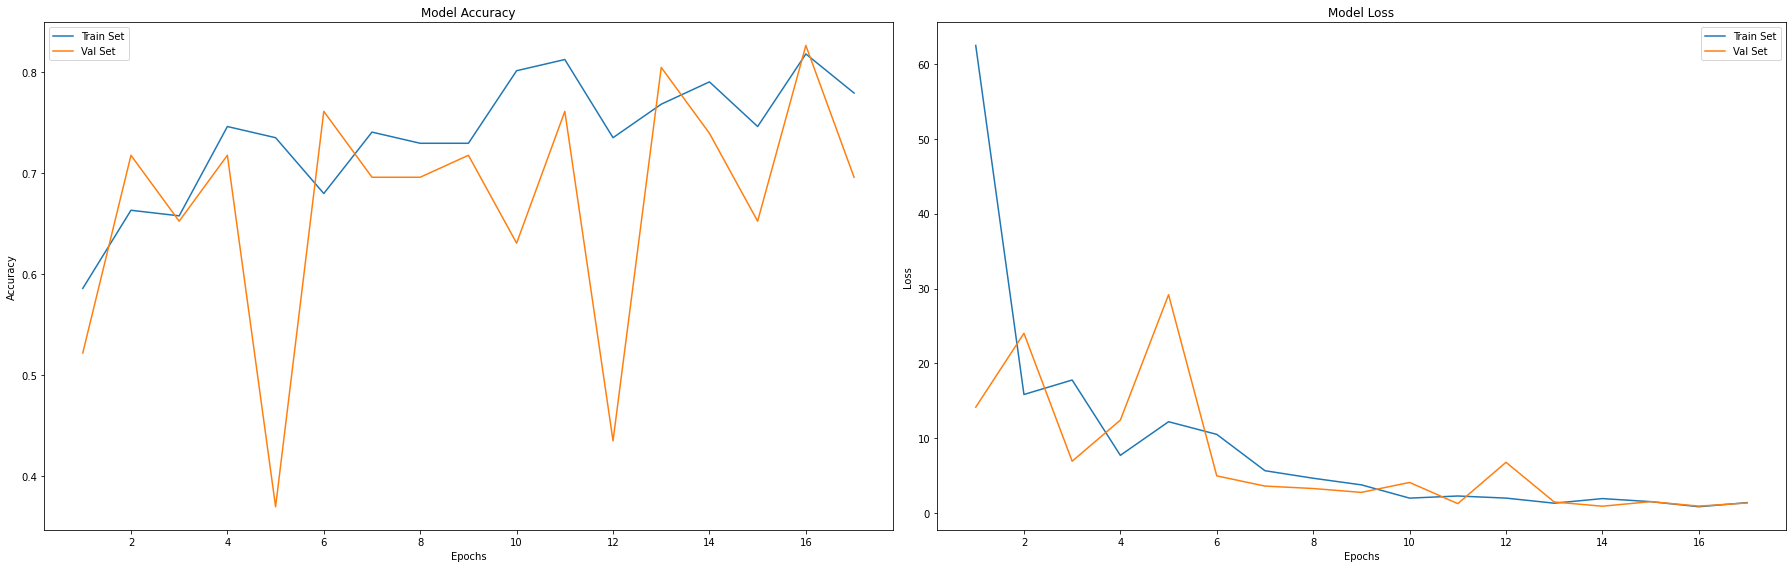

In [61]:
plot_accuracy_loss(histincV3)

In [62]:
modelV3.load_weights(PATH_MODEL + "Tumor_classifier_model_InceptionV3.h5")
modelV3.evaluate(test_generator)

3/3 [==============================] - 1s 277ms/step - loss: 0.7579 - accuracy: 0.8462


[0.7579335570335388, 0.8461538553237915]

### Predicciones InceptionV3

Predicción: [[1.]]


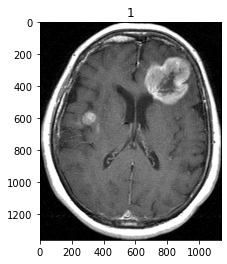

In [64]:
pred_input(modelV3, preprocess_inputInceptionV3,IMG_SIZE, test_df)

<a name="VGG19"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a>
## Modelo CNN VGG19

In [65]:
base_model = VGG19(input_shape = (IMG_SIZE,IMG_SIZE,3),
                  include_top = False,
                  weights = 'imagenet'  #None para entrenarla de cero sin quedarte la parte convolucionada preentrenada
                  ) 

for layer in base_model.layers:
    layer.trainable = False

##### FULLY CONNECTED LAYER #####
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(2048, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

modelVGG19 = tf.keras.models.Model(base_model.input, x)

modelVGG19.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics = ['accuracy'])

In [66]:
vgghist19 = modelVGG19.fit(train_generator,
                    validation_data = validation_generator,
                    callbacks = [call_backs(PATH_MODEL + "Tumor_classifier_model_VGG19.h5")],
                    epochs = EPOCHS,
                    verbose = 1)

Epoch 1/50
19/19 [==============================] - 46s 2s/step - loss: 4.6273 - accuracy: 0.5470 - val_loss: 1.5862 - val_accuracy: 0.4565
Epoch 2/50
19/19 [==============================] - 45s 2s/step - loss: 2.0362 - accuracy: 0.6133 - val_loss: 0.7835 - val_accuracy: 0.7609
Epoch 3/50
19/19 [==============================] - 47s 3s/step - loss: 2.2807 - accuracy: 0.6519 - val_loss: 1.1769 - val_accuracy: 0.7391
Epoch 4/50
19/19 [==============================] - 48s 3s/step - loss: 2.5501 - accuracy: 0.6188 - val_loss: 1.3633 - val_accuracy: 0.7391
Epoch 5/50
19/19 [==============================] - 54s 3s/step - loss: 1.9273 - accuracy: 0.6796 - val_loss: 0.6295 - val_accuracy: 0.8043
Epoch 6/50
19/19 [==============================] - 53s 3s/step - loss: 1.0269 - accuracy: 0.7514 - val_loss: 0.4502 - val_accuracy: 0.7826
Epoch 7/50
19/19 [==============================] - 53s 3s/step - loss: 1.4402 - accuracy: 0.6961 - val_loss: 1.0498 - val_accuracy: 0.6304
Epoch 8/50
19/19 [==

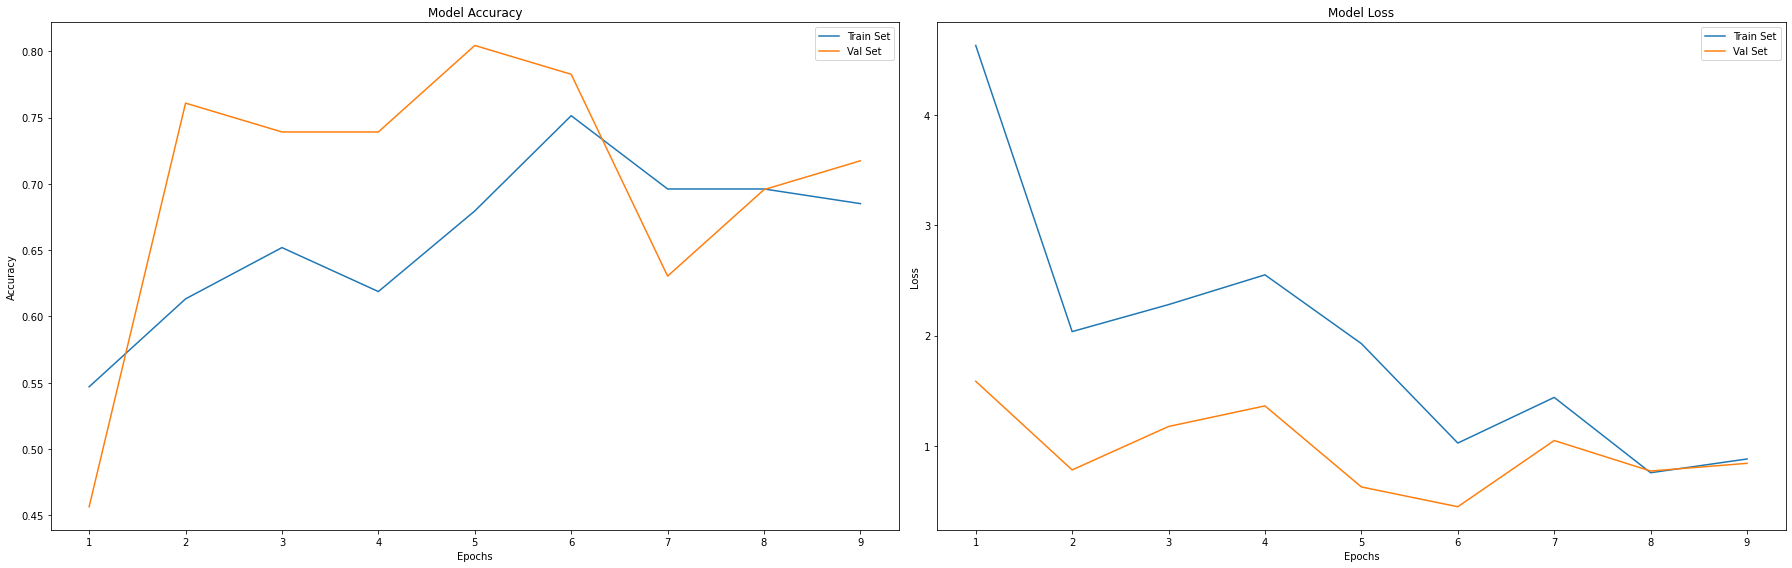

In [67]:
plot_accuracy_loss(vgghist19)

In [68]:
modelVGG19.load_weights(PATH_MODEL + "Tumor_classifier_model_VGG19.h5")
modelVGG19.evaluate(test_generator)

3/3 [==============================] - 4s 1s/step - loss: 0.8521 - accuracy: 0.7308


[0.8520569205284119, 0.7307692170143127]

### Predicción de imagenes

Predicción: [[1.]]


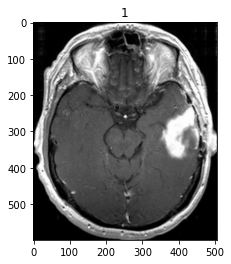

In [69]:
pred_input(modelVGG19, preprocess_inputVGG19,IMG_SIZE, test_df);